# Klasifikace zvukov√Ωch z√°znam≈Ø 
## Vypracovali Marek Tremel, Radek Nov√°k a Kseniia Mahalias

**Zad√°n√≠**: Ve zdrojov√© datab√°zi najdete celkem 208 hlasov√Ωch z√°znam≈Ø p√≠smene a. Pomoc√≠ V√°mi vybran√©
techniky v ƒçasov√© nebo frekvenƒçn√≠ oblasti klasifikujte zvukov√© z√°znamy na dobr√© a patologick√©.
V p≈ô√≠padƒõ patologick√Ωch pot√© klasifikujte jednotliv√© poruchy. Jejich v√Ωƒçet najdete buƒè
v hlaviƒçkov√Ωch souborech nebo v propisu datab√°ze. Pro klasifikaci do jednotliv√Ωch skupin
pou≈æijte ve≈°ker√© techniky, kter√© jste si v r√°mci kurzu osvojili vƒçetnƒõ Fourierovy a kepstr√°ln√≠
anal√Ωzy. √öspƒõ≈°nost Va≈°eho postupu porovnejte s anotacemi, resp. roz≈ôazen√≠m do skupin, kter√©
provedli experti, kte≈ô√≠ data po≈ôizovali.

----------


## Pou≈æit√© knihovny

In [3]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import re
import librosa.display # –ø—Ä–æ vizualizac–µ anal√Ωzy zvuku -- —î–¥–∏–Ω–∞ –±—ñ–±–ª—ñ–æ—Ç–µ–∫–∞ —è–∫—É —è –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É–≤–∞–ª–∞ –≤–ø–µ—Ä—à–µ, 
import seaborn as sns

ModuleNotFoundError: No module named 'librosa'

## Funkce: parse_diagnosis(info_file_path)

Zadan√° funkce extrahuje diagnostick√© informace ze souboru -info.txt, kter√° obsahuje p√≠semn√© informaci o diagn√≥ze.

In [7]:
def parse_diagnosis(info_file_path):
    """
    Parsuje diagnostickou informaci z textov√©ho souboru.

    Parametry:
    info_file_path : str
        Cesta k souboru obsahuj√≠c√≠mu informace o diagn√≥ze.

    N√°vratov√° hodnota:
    str : Diagn√≥za jako ≈ôetƒõzec, pokud byla nalezena, jinak NONE.
    """
    with open(info_file_path, "r") as f:  # Otev≈ôen√≠ souboru pro ƒçten√≠
        content = f.read()  # Naƒçten√≠ obsahu souboru

        # Hled√°n√≠ ≈ô√°dku obsahuj√≠c√≠ho "Diagnosis: " a n√°slednƒõ diagnostick√Ω text
        diagnosis_match = re.search(r"Diagnosis:\s+(.+)", content)

        if diagnosis_match:
            return diagnosis_match.group(
                1
            ).strip()  # Vr√°cen√≠ extrahovan√© diagn√≥zy bez mezer

    return None  # Pokud diagn√≥za nebyla nalezena, vr√°t√≠ NONE

## V√Ωpoƒçet energie sign√°lu
`signal**2`: Pro v√Ωpoƒçet energie se ka≈æd√Ω vzorek sign√°lu vyn√°sob√≠ ƒçtvercem.

`signal**2)`: Pr≈Ømƒõrn√° hodnota ƒçtverce vzork≈Ø pro v√Ωpoƒçet pr≈Ømƒõrn√© energie sign√°lu.

`signal.abs()`: Jako ochrann√Ω krok se p≈ôiƒçte absolutn√≠ hodnota.


## V√Ωpoƒçet jitteru
V anal√Ωze hlasu je jitter popisem naru≈°en√≠ periody kmit√°n√≠ hlasu (nap≈ô√≠klad zmƒõna jeho frekvence). 

`n.sign(signal)`: Tato funkce p≈ôev√°d√≠ sign√°l na jeho znam√©nko:
- Kladn√© hodnoty - 1
- Z√°porn√© hodnoty - -1
- Nulov√© hodnoty - 0

`p.diff()` : vypoƒç√≠t√° rozd√≠ly mezi sousedn√≠mi prvky. 

`np.where(...)[0]`: zobraz√≠ indexy, kde se zmƒõnilo znam√©nko (tj. byla p≈ôed√°na nula).



In [8]:

# Funkce pro v√Ωpoƒçet energie sign√°lu
def compute_energy(signal):
    return np.abs(np.mean(signal**2))


# Funkce pro v√Ωpoƒçet jitteru
def compute_jitter(signal, fs):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return len(zero_crossings) / len(signal)


## ƒåten√≠ a zpracov√°n√≠ hlasov√Ωch sign√°l≈Ø
Urƒçen√≠ datov√© cesty
2.ƒåten√≠ seznamu soubor≈Ø
3.Inicializace seznamu v√Ωsledk≈Ø
4.Zpracov√°n√≠ soubor≈Ø
Pro ka≈æd√Ω soubor:
- Nastav√≠me vzorkovac√≠ frekvenci na 8000 Hz.
- Vypoƒç√≠t√°me energii pomoc√≠ p≈ô√≠kazu compute_energy.
- Vypoƒç√≠t√°me jitter pomoc√≠ compute_jitter.
- Vypoƒç√≠t√°me MFCC a jejich variace (nap≈ô. std).

In [17]:
# Cesta k adres√°≈ôi se soubory hlasov√Ωch z√°znam≈Ø
data_dir = "../data/voices"

# Seznam v≈°ech soubor≈Ø v adres√°≈ôi
dat_files = [f for f in os.listdir(data_dir) if f.endswith(".dat")]

# Seznam pro ulo≈æen√≠ v√Ωsledk≈Ø
results = []
mfcc_variabilities = []  # Sb√≠r√°me hodnoty pro v√Ωpoƒçet pr≈Ømƒõru

for dat_file in dat_files:
    file_path = os.path.join(data_dir, dat_file)
    info_file_path = os.path.join(data_dir, dat_file.replace(".dat", "-info.txt"))

    try:
        # Naƒçten√≠ sign√°lu jako bin√°rn√≠ho souboru
        signal = np.fromfile(file_path, dtype=np.int16)
        fs = 8000  # vzorkovac√≠ frekvenci 8000 Hz podle naƒçten√Ωch dat

        # V√Ωpoƒçet p≈ô√≠znak≈Ø
        energy = compute_energy(signal)
        jitter = compute_jitter(signal, fs)
        mfccs = librosa.feature.mfcc(y=signal.astype(float), sr=fs, n_mfcc=13)
        mfcc_variability = np.std(mfccs)

        # Ulo≈æen√≠ hodnoty MFCC variability pro anal√Ωzu
        mfcc_variabilities.append(mfcc_variability)

        real_diagnosis = parse_diagnosis(info_file_path)

        results.append([dat_file, energy, jitter, mfcc_variability, real_diagnosis])

    except Exception as e:
        print(f"‚ùå Chyba p≈ôi naƒç√≠t√°n√≠ {dat_file}: {e}")
        continue

## Z√°pis do datov√© sady a souboru CSV, obecn√© hodnocen√≠ a rozdƒõlen√≠ na spr√°vn√© a nespr√°vn√©.
1.Z√°pis do datov√© sady v programu pandas. Ve≈°ker√° data z hlasov√©ho z√°znamu byla ulo≈æena do datov√©ho souboru pomoc√≠ knihovny pandas, co≈æ umo≈ænilo efektivn√≠ ukl√°d√°n√≠ a manipulaci s daty v tabulkov√© podobƒõ.
2.Zobrazen√≠ celkov√Ωch v√Ωsledk≈Ø. Po zpracov√°n√≠ dat se zobraz√≠ celkov√© v√Ωsledky, kter√© zahrnuj√≠ informace o poƒçtu spr√°vn√Ωch a nespr√°vn√Ωch nahr√°vek. Tyto v√Ωsledky jsou u≈æiteƒçn√© pro dal≈°√≠ anal√Ωzu a ovƒõ≈ôen√≠ klasifikace.
3.Klasifikace hlasov√Ωch z√°znam≈Ø. N√°stroj Classify_voice automaticky klasifikuje hlasov√© nahr√°vky na z√°kladƒõ t≈ô√≠ kl√≠ƒçov√Ωch charakteristik:
-Energie hlasu: Mƒõ≈ô√≠ intenzitu zvuku v nahr√°vce.
-Jitter (frekvenƒçn√≠ nepravidelnost): Identifikuje nepravidelnosti ve frekvenci hlasu.
-MFCC variabilita (Mel-frekvenƒçn√≠ cepstr√°ln√≠ koeficienty): Popisuje zmƒõny zvukov√Ωch charakteristik v ƒçase, kter√© jsou d≈Øle≈æit√© pro rozli≈°en√≠ r≈Øzn√Ωch typ≈Ø hlasu.
4.Z√°pis do souboru CSV. Po klasifikaci se data ulo≈æ√≠ do souboru CSV, co≈æ umo≈æ≈àuje snadn√© ukl√°d√°n√≠ v√Ωsledk≈Ø a n√°slednou anal√Ωzu. Soubor obsahuje informace o nahr√°vk√°ch, jejich vlastnostech a p≈ôi≈ôazen√Ωch t≈ô√≠d√°ch (spr√°vn√©/nespr√°vn√©).

In [20]:
# Anal√Ωza datasetu V√Ωpoƒçet pr≈Ømƒõrn√© MFCC variability a odchylky
df = pd.DataFrame(
    results,
    columns=["Filename", "Energy", "Jitter", "MFCC Variability", "Real Diagnosis"],
)
mean_mfcc = df["MFCC Variability"].mean()
std_mfcc = df["MFCC Variability"].std()

# Nov√© hranice na z√°kladƒõ percentil≈Ø datasetu
energy_threshold = df["Energy"].mean()  # Pr≈Ømƒõrn√° hodnota energie
jitter_threshold = df["Jitter"].mean()  # Pr≈Ømƒõrn√° hodnota jitteru
mfcc_threshold = mean_mfcc + (std_mfcc * 0.8)  # P≈ô√≠snƒõj≈°√≠ MFCC limit

print(f"üìä Pr≈Ømƒõrn√° MFCC variabilita: {mean_mfcc:.2f}")
print(f"üìä Smƒõrodatn√° odchylka MFCC: {std_mfcc:.2f}")
print(f"üìä Energy threshold: {energy_threshold:.3f}")
print(f"üìä Jitter threshold: {jitter_threshold:.3f}")
print(f"üìä MFCC threshold: {mfcc_threshold:.3f}")


# KlasiÔ¨Åkace hlasov√Ωch z√°znam≈Ø
def classify_voice(energy, jitter, mfcc_variability):
    if (
        energy < energy_threshold
        or jitter > jitter_threshold
        or mfcc_variability > mfcc_threshold
    ):
        return "Patologick√Ω"
    else:
        return "Dobr√Ω"


df["Classification"] = df.apply(
    lambda row: classify_voice(row["Energy"], row["Jitter"], row["MFCC Variability"]),
    axis=1,
)

# **Ulo≈æen√≠ v√Ωsledk≈Ø do CSV**
df.to_csv("classification_results.csv", index=False)
print("‚úÖ V√Ωsledky klasifikace byly ulo≈æeny do classification_results.csv")

üìä Pr≈Ømƒõrn√° MFCC variabilita: 316.65
üìä Smƒõrodatn√° odchylka MFCC: 0.85
üìä Energy threshold: 350.951
üìä Jitter threshold: 0.505
üìä MFCC threshold: 317.334
‚úÖ V√Ωsledky klasifikace byly ulo≈æeny do classification_results.csv


## Vizualizace
V projektu byly pro prvn√≠ t≈ôi sign√°ly vytvo≈ôeny grafy, aby bylo mo≈æn√© l√©pe pochopit jejich charakteristiky:

ƒåasov√Ω graf: Vytvo≈ôen√Ω pomoc√≠ funkce plt.plot, kter√Ω zobrazuje zmƒõny sign√°lu v ƒçase.
Spektrogram: Pomoc√≠ funkce librosa.stft (kr√°tkodob√° Fourierova transformace) byl vypoƒçten spektrogram, kter√Ω byl vizualizov√°n pomoc√≠ librosa.display.specshow a umo≈ænil frekvenƒçn√≠ anal√Ωzu sign√°lu v r≈Øzn√Ωch ƒçasov√Ωch okam≈æic√≠ch.

## Vizualizace rozlo≈æen√≠ t≈ô√≠d
K zobrazen√≠ rozlo≈æen√≠ sign√°l≈Ø podle t≈ô√≠d (spr√°vn√© vs. nespr√°vn√©) byl pou≈æit sloupcov√Ω graf vytvo≈ôen√Ω pomoc√≠ funkce seaborn.countplot. Tento graf zobrazuje poƒçet sign√°l≈Ø v jednotliv√Ωch t≈ô√≠d√°ch, co≈æ umo≈æ≈àuje rychl√© srovn√°n√≠ poƒçtu spr√°vn√Ωch a nespr√°vn√Ωch z√°znam≈Ø.


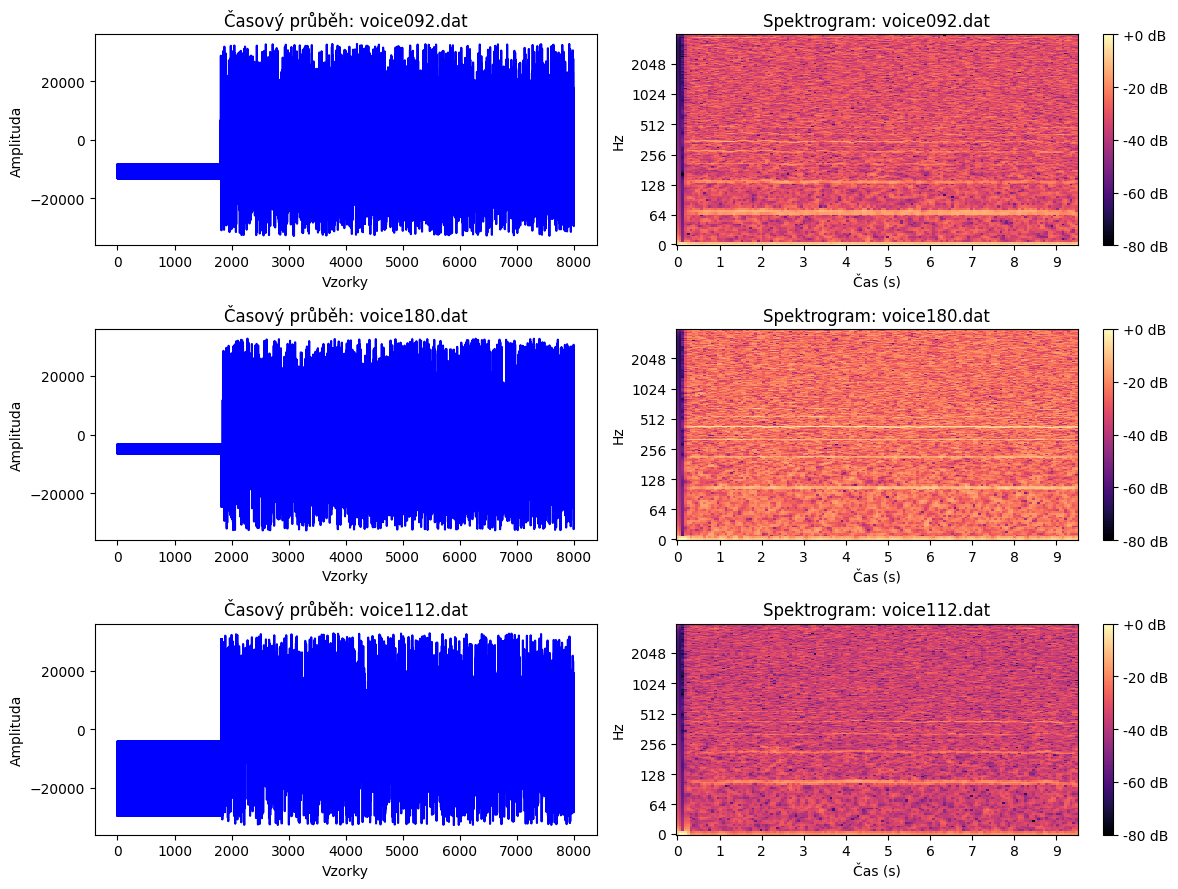

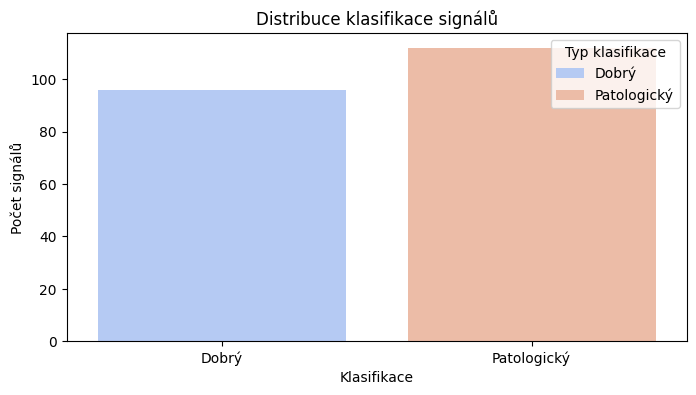

In [19]:
# Vybereme prvn√≠ t≈ôi ≈ô√°dky pro vizualizaci
samples_to_plot = df.head(3)

fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i, row in enumerate(samples_to_plot.itertuples(), 0):
    file_path = os.path.join(data_dir, row.Filename)
    signal = np.fromfile(file_path, dtype=np.int16)

    # ƒåasov√Ω pr≈Øbƒõh sign√°lu
    axes[i, 0].plot(signal[:8000], color="blue")
    axes[i, 0].set_title(f"ƒåasov√Ω pr≈Øbƒõh: {row.Filename}")
    axes[i, 0].set_xlabel("Vzorky")
    axes[i, 0].set_ylabel("Amplituda")

    # Spektrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal.astype(float))), ref=np.max)
    img = librosa.display.specshow(
        D, sr=8000, x_axis="time", y_axis="log", ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"Spektrogram: {row.Filename}")
    axes[i, 1].set_xlabel("ƒåas (s)")

    # P≈ôid√°n√≠ barevn√© ≈°k√°ly ke spektrogramu
    fig.colorbar(img, ax=axes[i, 1], format="%+2.0f dB")

plt.tight_layout()
plt.show()

# Vizualizace distribuce klasifikace
plt.figure(figsize=(8, 4))
sns.countplot(x="Classification", hue="Classification", data=df, palette="coolwarm", legend=True)
plt.title("Distribuce klasifikace sign√°l≈Ø")
plt.xlabel("Klasifikace")
plt.ylabel("Poƒçet sign√°l≈Ø")
plt.legend(title="Typ klasifikace")
plt.show()

## S hrnut√≠ 

V r√°mci √∫lohy bylo zpracov√°no 208 hlasov√Ωch z√°znam≈Ø, kter√© byly klasifikov√°ny jako spr√°vn√© nebo nespr√°vn√©. K anal√Ωze byly pou≈æity metody jako Fourierova anal√Ωza a cepstr√°ln√≠ anal√Ωza. Shrom√°≈ædƒõn√° data zahrnovala energii sign√°lu, jitter (nepravidelnost) a variace mel-frekvenƒçn√≠ho cepstr√°ln√≠ho koeficientu (MFCC).

Na z√°kladƒõ pr≈Ømƒõrn√Ωch hodnot tƒõchto znak≈Ø byla provedena klasifikace, jej√≠≈æ v√Ωsledky byly porovn√°ny s odborn√Ωmi posudky. Projekt se zamƒõ≈ôil na vyu≈æit√≠ Fourierovy a cepstr√°ln√≠ anal√Ωzy, kter√© se uk√°zaly jako u≈æiteƒçn√© pro pokroƒçilej≈°√≠ zpracov√°n√≠ sign√°lu.



[Digital signal processing](https://en.wikipedia.org/wiki/Digital_signal_processing)

[Speech recognition](https://en.wikipedia.org/wiki/Speech_recognition)

[MFCC](https://stackoverflow.com/questions/60492462/mfcc-python-completely-different-result-from-librosa-vs-python-speech-features)
